## T-GCN

### Algorithm

+ 先理一下, 看看论文和代码
+ 唔, 他这个就等于做完GraphConv之后扔到GRU里去算一个hidden state, 或者说output
+ 那这个hidden的shape是? ok自己指定的
+ 所以我要使用PyG做的话, 应该就是套着来, 写个loop, 里面是conv得到的结果扔到GRU
+ 但是有个问题, GRU默认自己处理多个seq的, 我这种不是等于单步的去处理吗?
+ 不对, 每个seq的conv本身又不依赖hidden state, 所以我就是每个seq都做conv之后, 再把seq作为seq扔到gru里去应该就可以
+ 就是得处理shape的问题, 这个麻烦..
***
+ 仔细看了他的代码, 额, 他是在原本GCN里的`AXW+b`这个式子里, 强行给X加了个h, 变成`A[X+h]W +b`, 然后去先更新一次Conv, 再去做GRU, 手动loop实现seq里h的迭代
+ 额, 和我想的还不太一样那.....
***
+ 我懂了, 他其实是把GRU里hidden state的更新也考虑了连接节点的影响, 就是不是`xW+b`, 而还是`AxW+b`, 额, 话说有必要吗, 如果我这样呢? `((AxW+b)+h)*W2+b2`, 就是我hidden_state不做A左乘, 而是直接拿去做计算? 感觉可以试试, 就当增进理解了...

In [1]:
import os, os.path
import sys
import time

In [2]:
import numpy as np
import pandas as pd

import torch
import torch_geometric as PyG
# from torch.nn import Linear
# import torch.nn as nn
# from torch_geometric.nn import GCNConv

from torch_geometric.data import Data
# from torch_geometric.loader import DataLoader


import matplotlib.pyplot as plt

import sys

sys.path.append('../../ai.rdee')

import ai_rdee

In [10]:
nNodes = 156
isep = 12
osep = 3

bs = 32

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
torch.cuda.memory_allocated()

0

In [6]:
# import torch
from torch_geometric.data import InMemoryDataset


class TGCN_dataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])
        self.eis = torch.load(self.processed_paths[1])

    @property
    def raw_file_names(self):
        return ['data/sz_adj.csv', 'data/sz_speed.csv']

    @property
    def processed_file_names(self):
        return ['data_sz.pt', 'eis.pt']

    def download(self):
        # Download to `self.raw_dir`.
        pass
        
    def process(self):
        # Read data into huge `Data` list.
        fn_adj, fn_spd = self.raw_file_names
        df_spd = pd.read_csv(fn_spd)
        S = df_spd.values.T
        df_adj = pd.read_csv(fn_adj, index_col=None, header = None)

        A = df_adj.values
        A.shape

        eis = torch.tensor(np.argwhere(A == 1).T)
        S = torch.Tensor(S)
        data_list = []
        for i in range(S.shape[1]-14):
            data = Data(x=S[:,i:i+12], y=S[:,i+12:i+15], edge_index=eis)
            data_list.append(data)
        
        
        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
        torch.save(eis, self.processed_paths[1])

In [11]:
dsG = TGCN_dataset('./data')

In [13]:
ratio_valid = 0.2
size_valid = int(ratio_valid * len(dsG))
size_learn = len(dsG) - size_valid

In [14]:
dsG_train, dsG_valid = torch.utils.data.random_split(dsG, [size_learn, size_valid])

In [15]:
dlr_train = PyG.loader.DataLoader(dsG_train, batch_size=bs, shuffle=True, drop_last=True)

In [16]:
dlr_valid = PyG.loader.DataLoader(dsG_valid, batch_size=len(dsG_valid))

In [17]:
dlr_train_noBatch = PyG.loader.DataLoader(dsG_train, batch_size=len(dsG_train))

In [18]:
torch.cuda.memory_allocated()

0

## Below blcok is used to check the data operation correctness

In [76]:
dlr = PyG.loader.DataLoader(dsG, batch_size=64, shuffle=False)

k = next(iter(dlr))
x = k.x

# x.shape
# x.view(64, -1, 12).shape

x2 = x.view(64, -1, 12).permute(2,0,1)
# x2.shape
# x2[:,0,:]

df = pd.read_csv('data/sz_speed.csv')
# df.iloc[:12, :].values
(x2[:,0,:] - torch.Tensor(df.iloc[:12, :].values)).max()

tensor(0.)

+ **GCN operator:**

$\mathbf{X}^{\prime} = \mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
\mathbf{\hat{D}}^{-1/2} \mathbf{X} \mathbf{\Theta},$

+ **GRU operator:**

$r= \sigma ( W_ {ir} x + b_ {ir} + W_ {hr} h+ b_ {hr} )$

$z= \sigma  (  W_ {iz}  x+  b_ {iz}  +  W_ {hz}  h+  b_ {hz}  )$

$n=  \tanh  (  W_ {in}  x+  b_ {in}  +r*(  W_ {hn}  h+  b_ {hn}  ))$

$h'=(1-z)*n+z*h$





+ 一种思路(T-GCN, GCN1GRU), 把GCN嵌入到GRU里去, 即在$W_ir, W_hr$等weight前都乘上一个$\hat{A}_{DD}$
+ 另一种思路(GCN2GRU), 把GCN传给GRU, 即GRU公式里的x是GCN得到的$X^{'}$
+ 都试试吧

## GCN1GRU

+ ok, 还是得自己写一个, fine, 就是把GCN融入到GRU里面去, 但其实核心还是GRU
+ 额, 这么看的话, 倒不如较GCN-GRU, T-GCN唔起的有点间接了哈哈
+ 那就是说, 我自己写一个GRUCell呗, 然后就是在具体的计算中去融入GCN的操作来更新node间的关系?
+ 好嘛, 换句话说, 就是在GRU中, 想了个法子用全连接+部分自连接来更新, 而不是单纯的全连接, 有道理
+ 那么问题来了, 我有什么法子把GRU给融入GCN而不仅仅是传输吗?
   * 比如说, 我用一个GRU去训练每一个node? 好像不行, 那就我针对每个node都搞一个GRU去训练? 咦这个思路回头试试, 先试这个然后看下一个论文, 过程中试试实际数据


In [19]:
eis = dsG.eis

In [20]:
eis.shape

torch.Size([2, 532])

In [21]:
class GCN1GRU(torch.nn.Module):
    def __init__(self, nNodes, input_dim, hidden_dim, output_dim, eis):
        super().__init__()
        self.GCNConv1 = PyG.nn.GCNConv(hidden_dim+1, hidden_dim)
        self.GCNConv2 = PyG.nn.GCNConv(hidden_dim+1, hidden_dim)
        self.GCNConv3 = PyG.nn.GCNConv(hidden_dim+1, hidden_dim)
#         self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.nNodes = nNodes
        self.regressor = torch.nn.Linear(hidden_dim, output_dim)
        self.register_buffer('eis', eis)
    
    def cell(self, inputs, hidden_state):
        # inputs: (batch_size, nNodes, nFeatures)
        # hidden_states: (batch_size, nNodes, nHidden)
        bs, nNodes, nFeatures = inputs.shape
        
        ih_concat = torch.cat((inputs, hidden_state), dim=2)  # ih_concat: (batch_size, nNodes, nFeatures + nHidden)
#         print(ih_concat.shape)
#         ih_bs2f = ih_concat.permute(1, 2, 0).view(nNodes, -1)  # ih_bs2f: (nNodes, (nFeatures+nHidden) * batch_size)
        r = torch.sigmoid(self.GCNConv1(ih_concat, self.eis))  # r : (batch_size, nNodes, nHidden)
        z = torch.sigmoid(self.GCNConv2(ih_concat, self.eis))  # z : (batch_size, nNodes, nHidden)
        n_ih_concat = torch.cat((inputs, r * hidden_state), dim=2)
        n = torch.tanh(self.GCNConv3(n_ih_concat, self.eis))  # n: (batch_size, nNodes, nHidden)
        hp = (1-z) * n + z * hidden_state
        return hp  # hp: (batch_size, nNodes, nHidden)
    
    def forward(self, inputs):
        # inputs: (batch_size, seq, nNodes, nFeatures)
        
        bs, nNodes, nSeq, nFeatures = inputs.shape
        
        hidden_state = torch.zeros(bs, nNodes, self.hidden_dim).type_as(inputs)
        for i in range(nSeq):
            hidden_state = self.cell(inputs[:, :, i, :], hidden_state)
        
        output = self.regressor(hidden_state)  # output: (batch_size, nNodes, output_dim)
        
        return output
        
        

In [22]:
net = GCN1GRU(nNodes, isep, 64, osep, eis)

+ The next block is used to check net.forward(...)

In [92]:

# dat0 = next(iter(dlr_train))

# dat0.x.shape

# y = net(dat0.x.view(dlr_train.batch_size, nNodes, isep, 1))

In [23]:
net.to(device)

GCN1GRU(
  (GCNConv1): GCNConv(65, 64)
  (GCNConv2): GCNConv(65, 64)
  (GCNConv3): GCNConv(65, 64)
  (regressor): Linear(in_features=64, out_features=3, bias=True)
)

In [24]:
criterion = torch.nn.MSELoss()
optim = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1.5e-3)
esp = ai_rdee.AiTools.EarlyStopping(100)

In [25]:
dataV = next(iter(dlr_valid))
yV = dataV.y.to(device)

In [26]:
lossesT = []
lossesE = []
lossesV = []
for epoch in range(3000):
    lossesE = []
    net.train()
#     print('before training: ', torch.cuda.memory_allocated())
    
    for data in dlr_train:
        optim.zero_grad()

        y_hat = net(data.x.view(dlr_train.batch_size, nNodes, isep, 1).to(device))
        loss = criterion(y_hat.view(-1), data.y.view(-1).to(device))
        if np.isnan(loss.item()):
            print("nan loss! Stop")
            break
        loss.backward()
        optim.step()
        lossesE.append(loss.item())
#         break
#     print('after training: ', torch.cuda.memory_allocated())
    
    lossesT.append(np.array(lossesE).mean())
    
    net.eval()

#     print('before validating: ', torch.cuda.memory_allocated())
    
    yV_hat = net(dataV.x.view(len(dsG_valid), nNodes, isep, 1).to(device))
#     print('after validating: ', torch.cuda.memory_allocated())
    
    lossesV.append(criterion(yV_hat.view(-1), yV.view(-1)).item())
#     print('after criterion: ', torch.cuda.memory_allocated())
    
    if epoch % 20 == 0:
        print(f"epoch={epoch}, lossT={lossesT[-1]:.3f}, lossV={lossesV[-1]:.3f}, minV={esp.val_loss_min:.3f}  |  @{time.ctime()}")

#         print(torch.cuda.memory_allocated())
    esp(lossesV[-1], net)
    if esp.early_stop:
        print(f"Early stopping at {epoch}")
        break
#     break

epoch=0, lossT=255.024, lossV=214.536, minV=inf  |  @Sun Oct  8 14:57:41 2023
epoch=20, lossT=44.128, lossV=46.259, minV=47.147  |  @Sun Oct  8 14:58:46 2023
epoch=40, lossT=35.181, lossV=37.349, minV=37.427  |  @Sun Oct  8 14:59:50 2023
epoch=60, lossT=33.381, lossV=35.596, minV=35.474  |  @Sun Oct  8 15:00:54 2023
epoch=80, lossT=32.673, lossV=34.958, minV=34.867  |  @Sun Oct  8 15:01:59 2023
epoch=100, lossT=32.234, lossV=34.328, minV=34.382  |  @Sun Oct  8 15:03:03 2023
epoch=120, lossT=31.963, lossV=34.290, minV=34.099  |  @Sun Oct  8 15:04:07 2023
epoch=140, lossT=31.753, lossV=33.817, minV=33.838  |  @Sun Oct  8 15:05:12 2023
epoch=160, lossT=31.433, lossV=33.706, minV=33.664  |  @Sun Oct  8 15:06:19 2023
epoch=180, lossT=31.337, lossV=33.594, minV=33.540  |  @Sun Oct  8 15:07:24 2023
epoch=200, lossT=31.176, lossV=33.492, minV=33.418  |  @Sun Oct  8 15:08:29 2023
epoch=220, lossT=31.052, lossV=33.378, minV=33.349  |  @Sun Oct  8 15:09:35 2023
epoch=240, lossT=30.976, lossV=33.3

In [101]:
rgp = ai_rdee.Regression.RegressionPerformance()

In [102]:
rgp.valid(yV_hat.view(-1).detach().cpu(), yV.view(-1).detach().cpu())

In [103]:
rgp.valid.show()

target : tg1
size   = 277056.000
r      =      0.899
r2     =      0.808
rmse   =      5.611
nRMSE  =      0.438
MSE    =     31.484


## GCN2GRU

+ 我靠, 不对啊, 有个问题, 我GCN完了之后, sequence就没了啊, 因为我变成了额, 一个hidden dim的feature, 他不再是那什么了?
+ 但是换个思路, 如果把12个也当成图, 我只要hidden dim是12的倍数, 然后拆出来得到seq就好?比如36, 那我理解为每个seq变成3个attr, 再和nnodes相乘, 变成seq, nnodes*nfeatures这样? 似乎也说得过去...试试
   * 有点怪, 因为GCNConv的时候, 比如12到36, 他是全连接的, 不是严格的比如, 每个去对应3个...额, 但是可以试试, 效果好不好另说

In [12]:
class GCN2GRU(torch.nn.Module):  # 
    def __init__(self, nNodes, input_dim, hidden_dim_GCN, hidden_dim_GRU, output_dim):
        super().__init__()
#         torch.manual_seed(925)
        self.conv1 = PyG.nn.GCNConv(input_dim, hidden_dim_GCN) # 只需定义好输入特征和输出特征即可
        self.gru = torch.nn.GRU(hidden_dim_GCN//input_dim*nNodes, nNodes*hidden_dim_GRU)
        self.regressor = torch.nn.Linear(nNodes*hidden_dim_GRU, nNodes*output_dim)

    def forward(self, x, edge_index):
        # x : (batch_size, nnodes, nFeatrues), edge_index: (2, nEdges)
#         print(x.shape)
        h = self.conv1(x, edge_index) # ->h: (batch_size, nNodes, n_hiddenG)
        h = h.tanh()
#         print(h.shape)
        bs, nn, nh = h.shape
        h = h.view(bs, nn * nh//12, 12).permute(2, 0, 1)
        out, h = self.gru(h)  # ->h: (1, batch_size, nNodes * hidden_dim_GRU)
        
        # 分类层
        out = self.regressor(h)

        return out

In [23]:
net = GCN2GRU(156, 12, 12, 20, 3)

In [24]:
torch.cuda.memory_allocated()

544496128

In [25]:
net.to(device)

GCN2GRU(
  (conv1): GCNConv(12, 24)
  (gru): GRU(312, 3120)
  (regressor): Linear(in_features=3120, out_features=468, bias=True)
)

In [26]:
torch.cuda.memory_allocated()

679718912

In [27]:
# model.double()

criterion = torch.nn.MSELoss()
optim = torch.optim.Adam(net.parameters())
# esp = ai_rdee.AiTools.EarlyStopping(200)


In [28]:
eis = dsG.eis

In [29]:
# dat0 = next(iter(dlr_train))

# y = net(dat0.x.view(64, -1, 12), eis)

# y.shape

# dat0.y.shape

In [30]:
esp = ai_rdee.AiTools.EarlyStopping(60)

In [31]:
dataV = next(iter(dlr_valid))
yV = dataV.y.to(device)

In [32]:
lossesT = []
lossesE = []
lossesV = []
for epoch in range(3000):
    lossesE = []
    net.train()
#     print('before training: ', torch.cuda.memory_allocated())
    
    for data in dlr_train:
        optim.zero_grad()

        y_hat = net(data.x.view(dlr_train.batch_size, -1, 12).to(device), eis.to(device))
        loss = criterion(y_hat.view(-1), data.y.view(-1).to(device))
        if np.isnan(loss.item()):
            print("nan loss! Stop")
            break
        loss.backward()
        optim.step()
        lossesE.append(loss.item())
#         break
#     print('after training: ', torch.cuda.memory_allocated())
    
    lossesT.append(np.array(lossesE).mean())
    
    net.eval()

#     print('before validating: ', torch.cuda.memory_allocated())
    
    yV_hat = net(dataV.x.view(len(dsG_valid), -1, 12).to(device), eis.to(device))
#     print('after validating: ', torch.cuda.memory_allocated())
    
    lossesV.append(criterion(yV_hat.view(-1), yV.view(-1)).item())
#     print('after criterion: ', torch.cuda.memory_allocated())
    
    if epoch % 10 == 0:
        print(f"epoch={epoch}, lossT={lossesT[-1]:.3f}, lossV={lossesV[-1]:.3f}, minV={esp.val_loss_min:.3f}  |  @{time.ctime()}")

#         print(torch.cuda.memory_allocated())
    esp(lossesV[-1], net)
    if esp.early_stop:
        print(f"Early stopping at {epoch}")
        break
#     break

epoch=0, lossT=122.853, lossV=54.862, minV=inf  |  @Sat Oct  7 17:08:09 2023
epoch=10, lossT=33.167, lossV=32.918, minV=32.842  |  @Sat Oct  7 17:08:25 2023
epoch=20, lossT=30.974, lossV=30.852, minV=30.895  |  @Sat Oct  7 17:08:36 2023
epoch=30, lossT=28.941, lossV=29.168, minV=28.999  |  @Sat Oct  7 17:08:52 2023
epoch=40, lossT=27.399, lossV=27.837, minV=27.972  |  @Sat Oct  7 17:09:05 2023
epoch=50, lossT=26.589, lossV=27.715, minV=27.533  |  @Sat Oct  7 17:09:18 2023
epoch=60, lossT=25.642, lossV=27.291, minV=27.296  |  @Sat Oct  7 17:09:31 2023
epoch=70, lossT=24.629, lossV=27.196, minV=27.218  |  @Sat Oct  7 17:09:44 2023
epoch=80, lossT=23.436, lossV=27.367, minV=27.196  |  @Sat Oct  7 17:09:54 2023
epoch=90, lossT=21.924, lossV=27.568, minV=27.196  |  @Sat Oct  7 17:10:03 2023
epoch=100, lossT=20.102, lossV=27.992, minV=27.196  |  @Sat Oct  7 17:10:12 2023
epoch=110, lossT=17.830, lossV=28.719, minV=27.196  |  @Sat Oct  7 17:10:21 2023
epoch=120, lossT=15.170, lossV=29.553, mi

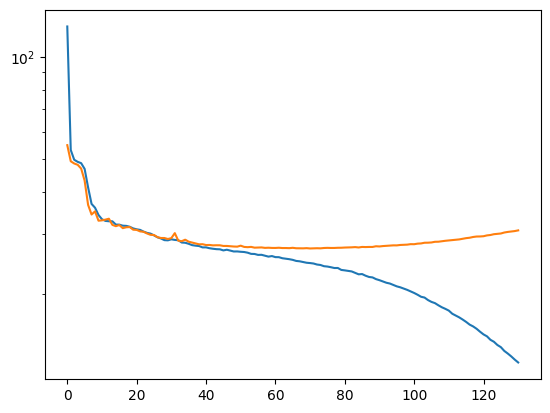

In [33]:
plt.plot(lossesT)
plt.plot(lossesV)
plt.yscale('log')

In [28]:
(5805547520 - 5455703552) / 8 / 1024 / 1024

41.70465087890625

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"The model has {num_params} trainable parameters")

In [43]:
net.eval()

GCN2GRU(
  (conv1): GCNConv(12, 36)
  (gru): GRU(468, 9984)
  (regressor): Linear(in_features=9984, out_features=468, bias=True)
)

In [48]:
dataTest = next(iter(dlr_test))
yT = dataTest.y.to(device)
yT_hat = net(dataTest.x.view(len(dsG_test), -1, 12).to(device), eis.to(device))

In [49]:
rgp = ai_rdee.Regression.RegressionPerformance()

In [50]:
yT.shape

torch.Size([92352, 3])

In [51]:
yT_hat.shape

torch.Size([1, 592, 468])

In [52]:
rgp.test(yT_hat.detach().cpu().view(-1), yT.detach().cpu().view(-1))

In [54]:
rgp.test.show()

target : tg1
size   = 277056.000
r      =      0.866
r2     =      0.741
rmse   =      6.471
nRMSE  =      0.509
MSE    =     41.875


In [57]:
dataTrain = next(iter(dlr_train_noBatch))
yT = dataTrain.y.to(device)
yT_hat = net(dataTrain.x.view(len(dsG_train), -1, 12).to(device), eis.to(device))

In [58]:
rgp.train(yT_hat.detach().cpu().view(-1), yT.detach().cpu().view(-1))

In [59]:
rgp.train.show()

target : tg1
size   = 1109160.000
r      =      1.000
r2     =      0.999
rmse   =      0.371
nRMSE  =      0.029
MSE    =      0.138
